## Question 2

In [2]:
# Cell 1: imports
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [3]:
# Cell 2: load & basic cleaning
df = sns.load_dataset("penguins")   # seaborn built-in dataset
df.dropna(inplace=True)            # remove rows with missing values

# Keep only two classes as in the assignment example
selected_classes = ['Adelie', 'Chinstrap']
df_filtered = df[df['species'].isin(selected_classes)].copy()

# sanity check
df_filtered[['species']].value_counts()


species  
Adelie       146
Chinstrap     68
Name: count, dtype: int64

In [4]:
# Cell 3: encode target and choose numeric features (important!)
le = LabelEncoder()
y = le.fit_transform(df_filtered['species'])   # 0/1 labels
# Use only numeric feature columns for X
X = df_filtered.select_dtypes(include=[np.number]).copy()

print("Features used:", list(X.columns))
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Features used: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
Class mapping: {'Adelie': np.int64(0), 'Chinstrap': np.int64(1)}


In [5]:
# Cell 4: split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
# Cell 5: train with saga (may need more iterations)
logreg = LogisticRegression(solver='saga', penalty='l2', max_iter=2000, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("SAGA Accuracy:", accuracy)
print("Coefficients:", logreg.coef_, "Intercept:", logreg.intercept_)


SAGA Accuracy: 0.6976744186046512
Coefficients: [[ 0.05301513 -0.00259315 -0.0019319  -0.00068938]] Intercept: [-0.00019593]


d:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [10]:
# Cell 6: liblinear solver
logreg_lib = LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000, random_state=42)
logreg_lib.fit(X_train, y_train)
acc_lib = accuracy_score(y_test, logreg_lib.predict(X_test))
print("LIBLINEAR Accuracy:", acc_lib)


LIBLINEAR Accuracy: 0.9767441860465116


In [11]:
# Cell 7: scale numeric features and compare solvers
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# saga on scaled
lg_saga_s = LogisticRegression(solver='saga', penalty='l2', max_iter=2000, random_state=42)
lg_saga_s.fit(X_train_s, y_train)
acc_saga_scaled = accuracy_score(y_test, lg_saga_s.predict(X_test_s))

# liblinear on scaled
lg_lib_s = LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000, random_state=42)
lg_lib_s.fit(X_train_s, y_train)
acc_lib_scaled = accuracy_score(y_test, lg_lib_s.predict(X_test_s))

print("SAGA unscaled:", accuracy)
print("LIBLINEAR unscaled:", acc_lib)
print("SAGA scaled:  ", acc_saga_scaled)
print("LIBLINEAR scaled:", acc_lib_scaled)


SAGA unscaled: 0.6976744186046512
LIBLINEAR unscaled: 0.9767441860465116
SAGA scaled:   1.0
LIBLINEAR scaled: 1.0


In [12]:
# Cell 8: run same training multiple times with different random_state for train_test_split
def eval_solver_over_random_states(solver_name='saga', scale=False, n_runs=20):
    accs = []
    for rs in range(n_runs):
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)
        if scale:
            sc = StandardScaler()
            Xtr = sc.fit_transform(Xtr)
            Xte = sc.transform(Xte)
        model = LogisticRegression(solver=solver_name, penalty='l2', max_iter=2000, random_state=42)
        model.fit(Xtr, ytr)
        accs.append(accuracy_score(yte, model.predict(Xte)))
    return accs

accs_saga = eval_solver_over_random_states('saga', scale=False, n_runs=30)
accs_lib   = eval_solver_over_random_states('liblinear', scale=False, n_runs=30)
print("Saga: mean {:.3f}, std {:.3f}".format(np.mean(accs_saga), np.std(accs_saga)))
print("Liblinear: mean {:.3f}, std {:.3f}".format(np.mean(accs_lib), np.std(accs_lib)))


d:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means 

Saga: mean 0.697, std 0.020
Liblinear: mean 0.982, std 0.018


In [10]:
# Cell 9: encoding categorical features - the correct approach
colors = pd.Series(['red','blue','green','blue','green'])
# BAD: label encode then scale - introduces ordinality
le = LabelEncoder()
labels = le.fit_transform(colors)
print("Label-encoded:", labels)

# GOOD: one-hot encode (no implicit ordinality)
onehot = pd.get_dummies(colors, prefix='color')
print("\nOne-hot:\n", onehot)

# Scaling a one-hot matrix usually not needed; if you scale it, you turn binaries into non-binary floats.


Label-encoded: [2 0 1 0 1]

One-hot:
    color_blue  color_green  color_red
0       False        False       True
1        True        False      False
2       False         True      False
3        True        False      False
4       False         True      False


## Question 2

In [15]:
# Cell 1: imports & helper functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from scipy.special import expit           # numerically-stable sigmoid
np.random.seed(0)

# Sigmoid (use expit for stability)
sigmoid = expit

# Binary cross-entropy (negative log-likelihood) per-sample
def log_loss(w, X, y, eps=1e-12):
    z = X @ w
    p = sigmoid(z)
    # clip for numerical stability
    p = np.clip(p, eps, 1 - eps)
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    return loss

# Gradient of logistic loss
def grad_log_loss(w, X, y):
    n = X.shape[0]
    p = sigmoid(X @ w)
    g = (X.T @ (p - y)) / n
    return g

# Hessian of logistic loss (matrix)
def hessian_log_loss(w, X, y, reg=0.0):
    n = X.shape[0]
    p = sigmoid(X @ w)
    W = p * (1 - p)                     # shape (n,)
    # Compute X.T @ diag(W) @ X efficiently
    XW = X * W[:, None]
    H = (X.T @ XW) / n
    if reg:
        H = H + reg * np.eye(H.shape[0])
    return H


In [16]:
# Cell 2: data generation (use the same transform as listing 3)
np.random.seed(0)
centers = [[-5, 0], [5, 1.5]]
X_raw, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = np.array([[0.5, 0.5], [-0.5, 1.5]])
X = X_raw.dot(transformation)   # apply linear transform (same as listing 3)

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (2000, 2) y shape: (2000,)


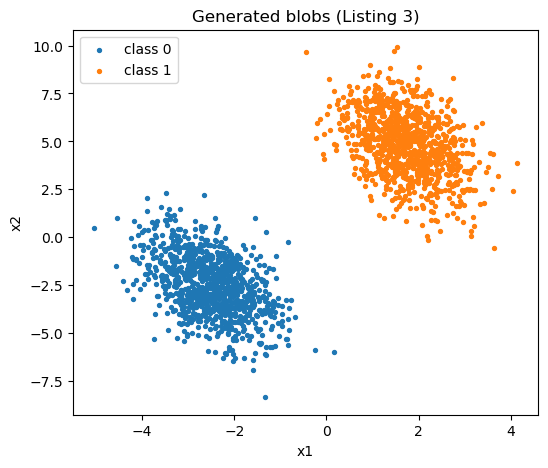

In [17]:
# Cell 3: visualize data (optional)
plt.figure(figsize=(6,5))
plt.scatter(X[y==0,0], X[y==0,1], s=8, label='class 0')
plt.scatter(X[y==1,0], X[y==1,1], s=8, label='class 1')
plt.legend()
plt.title("Generated blobs (Listing 3)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()


In [18]:
# Cell 4: prepare X (add bias/intercept column) and split
# We will not standardize here because we want to see raw convergence behaviour.
# For numerical stability in Newton, we add tiny regularization when needed.

# Add bias column (intercept)
X_with_bias = np.hstack([np.ones((X.shape[0],1)), X])   # shape (n, 3) -> [1, x1, x2]

# train-test for evaluation (not required by algorithm but helpful)
X_train, X_test, y_train, y_test = train_test_split(X_with_bias, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1600, 3) Test shape: (400, 3)


In [19]:
# Cell 5: Batch Gradient Descent function
def batch_gradient_descent(X, y, lr=0.1, n_iters=20, w_init=None, verbose=False):
    n, d = X.shape
    if w_init is None:
        # Initialization choice: zeros (common, symmetry broken by data)
        # Reason: For logistic regression, w=0 is a valid, neutral starting point
        # (sigmoid(0)=0.5) that does not bias features and is standard practice.
        w = np.zeros(d)
    else:
        w = w_init.copy()
    losses = []
    for it in range(n_iters):
        loss = log_loss(w, X, y)
        losses.append(loss)
        g = grad_log_loss(w, X, y)
        w = w - lr * g
        if verbose:
            print(f"Iter {it+1}/{n_iters} - loss: {loss:.6f}")
    return w, np.array(losses)

# Short test run (20 iters) — choose lr after quick experimentation
w_gd, losses_gd = batch_gradient_descent(X_train, y_train, lr=0.2, n_iters=20, verbose=True)
print("Final GD loss:", losses_gd[-1])
print("GD weights:", w_gd)


Iter 1/20 - loss: 0.693147
Iter 2/20 - loss: 0.182040
Iter 3/20 - loss: 0.128045
Iter 4/20 - loss: 0.101064
Iter 5/20 - loss: 0.084344
Iter 6/20 - loss: 0.072798
Iter 7/20 - loss: 0.064277
Iter 8/20 - loss: 0.057695
Iter 9/20 - loss: 0.052438
Iter 10/20 - loss: 0.048131
Iter 11/20 - loss: 0.044531
Iter 12/20 - loss: 0.041472
Iter 13/20 - loss: 0.038837
Iter 14/20 - loss: 0.036542
Iter 15/20 - loss: 0.034523
Iter 16/20 - loss: 0.032731
Iter 17/20 - loss: 0.031130
Iter 18/20 - loss: 0.029690
Iter 19/20 - loss: 0.028386
Iter 20/20 - loss: 0.027201
Final GD loss: 0.0272007041768986
GD weights: [-0.08194225  0.70305646  0.8017978 ]


In [20]:
# Cell 7: Newton's method (20 iterations)
def newton_method(X, y, n_iters=20, w_init=None, reg=1e-6, verbose=False):
    n, d = X.shape
    if w_init is None:
        w = np.zeros(d)
    else:
        w = w_init.copy()
    losses = []
    for it in range(n_iters):
        loss = log_loss(w, X, y)
        losses.append(loss)
        g = grad_log_loss(w, X, y)
        H = hessian_log_loss(w, X, y, reg=reg)
        # Solve H * delta = g  -> delta = H^{-1} g
        # Update: w <- w - delta (Newton step)
        try:
            delta = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            # fallback: pseudo-inverse
            delta = np.linalg.pinv(H) @ g
        w = w - delta
        if verbose:
            print(f"Newton iter {it+1}/{n_iters} - loss: {loss:.6f}")
    return w, np.array(losses)

w_newton, losses_newton = newton_method(X_train, y_train, n_iters=20, verbose=True)
print("Final Newton loss:", losses_newton[-1])
print("Newton weights:", w_newton)


Newton iter 1/20 - loss: 0.693147
Newton iter 2/20 - loss: 0.145507
Newton iter 3/20 - loss: 0.052967
Newton iter 4/20 - loss: 0.020448
Newton iter 5/20 - loss: 0.008091
Newton iter 6/20 - loss: 0.003256
Newton iter 7/20 - loss: 0.001331
Newton iter 8/20 - loss: 0.000553
Newton iter 9/20 - loss: 0.000233
Newton iter 10/20 - loss: 0.000099
Newton iter 11/20 - loss: 0.000042
Newton iter 12/20 - loss: 0.000017
Newton iter 13/20 - loss: 0.000007
Newton iter 14/20 - loss: 0.000003
Newton iter 15/20 - loss: 0.000001
Newton iter 16/20 - loss: 0.000001
Newton iter 17/20 - loss: 0.000000
Newton iter 18/20 - loss: 0.000000
Newton iter 19/20 - loss: 0.000000
Newton iter 20/20 - loss: 0.000000
Final Newton loss: 1.6436401959354568e-07
Newton weights: [-1.89305919  7.65396874  3.40578194]


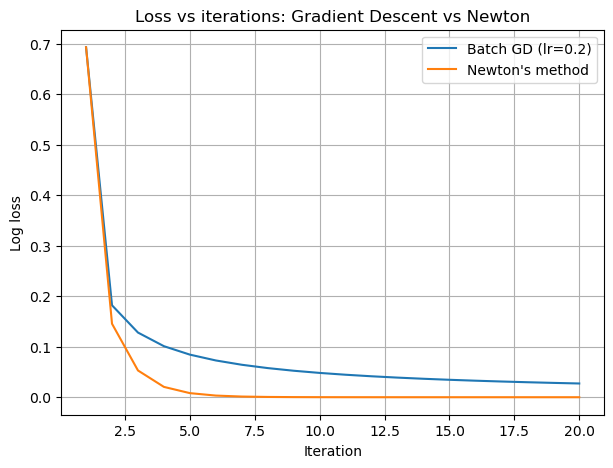

In [21]:
# Cell 8: plot loss histories
plt.figure(figsize=(7,5))
plt.plot(np.arange(1, len(losses_gd)+1), losses_gd, label='Batch GD (lr=0.2)')
plt.plot(np.arange(1, len(losses_newton)+1), losses_newton, label="Newton's method")
plt.xlabel("Iteration")
plt.ylabel("Log loss")
plt.title("Loss vs iterations: Gradient Descent vs Newton")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Cell 9: compute test accuracies for both methods
def predict_proba(w, X):
    return sigmoid(X @ w)

def predict(w, X, thresh=0.5):
    return (predict_proba(w, X) >= thresh).astype(int)

for name, w in [('GD', w_gd), ("Newton", w_newton)]:
    yhat = predict(w, X_test)
    acc = (yhat == y_test).mean()
    print(f"{name} test accuracy: {acc:.4f}")


GD test accuracy: 1.0000
Newton test accuracy: 1.0000


In [23]:
# Cell 10: Two approaches to decide number of iterations

# Approach A: fixed relative tolerance on loss change
def gd_with_tol(X, y, lr=0.2, max_iters=1000, tol=1e-6):
    w = np.zeros(X.shape[1])
    losses = []
    for it in range(max_iters):
        loss = log_loss(w, X, y)
        losses.append(loss)
        g = grad_log_loss(w, X, y)
        w = w - lr * g
        if it > 0 and abs(losses[-2] - losses[-1]) < tol:
            return w, np.array(losses), it+1
    return w, np.array(losses), max_iters

w_tol, losses_tol, niters_tol = gd_with_tol(X_train, y_train, lr=0.2, max_iters=10000, tol=1e-8)
print("Approach A (tol): stopped at iteration", niters_tol, "final loss", losses_tol[-1])

# Approach B: early stopping using validation set and patience
def gd_with_early_stopping(X, y, lr=0.2, max_iters=10000, val_frac=0.2, patience=10):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=val_frac, random_state=1, stratify=y)
    w = np.zeros(X.shape[1])
    best_val = np.inf
    best_w = w.copy()
    wait = 0
    train_losses = []
    for it in range(max_iters):
        train_loss = log_loss(w, X_tr, y_tr)
        train_losses.append(train_loss)
        g = grad_log_loss(w, X_tr, y_tr)
        w = w - lr * g
        val_loss = log_loss(w, X_val, y_val)
        if val_loss < best_val - 1e-12:
            best_val = val_loss
            best_w = w.copy()
            wait = 0
        else:
            wait += 1
        if wait >= patience:
            return best_w, np.array(train_losses), it+1, best_val
    return w, np.array(train_losses), max_iters, best_val

w_es, losses_es, niters_es, best_val = gd_with_early_stopping(X_train, y_train, lr=0.2, patience=20)
print("Approach B (early stopping): stopped at", niters_es, "best validation loss", best_val)


Approach A (tol): stopped at iteration 10000 final loss 0.00014624233758346933
Approach B (early stopping): stopped at 10000 best validation loss 0.0002453908674650203


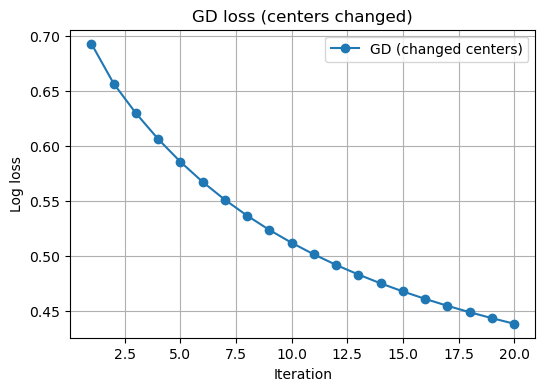

GD (changed centers) test accuracy after 20 iters: 0.845


In [24]:
# Cell 11: Q7 - change centers and analyze convergence
np.random.seed(0)
centers_new = [[2, 2], [5, 1.5]]
X_raw2, y2 = make_blobs(n_samples=2000, centers=centers_new, random_state=5)
transformation = np.array([[0.5, 0.5], [-0.5, 1.5]])
X2 = X_raw2.dot(transformation)
X2_with_bias = np.hstack([np.ones((X2.shape[0],1)), X2])

# train/test
X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2_with_bias, y2, test_size=0.2, random_state=42, stratify=y2)

# run batch GD (same lr and iters)
w2_gd, losses2_gd = batch_gradient_descent(X2_tr, y2_tr, lr=0.2, n_iters=20, verbose=False)

# Plot loss for this new config
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(losses2_gd)+1), losses2_gd, marker='o', label='GD (changed centers)')
plt.xlabel("Iteration"); plt.ylabel("Log loss"); plt.title("GD loss (centers changed)")
plt.grid(True); plt.legend(); plt.show()

# Evaluate on test set
acc2 = (predict(w2_gd, X2_te) == y2_te).mean()
print("GD (changed centers) test accuracy after 20 iters:", acc2)
